# Install and import libraries

In [1]:
# Import Libraries
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

import warnings
warnings.filterwarnings("ignore")

# Set HPO
optHPO = False # CHange to True if you need to perform HPO

In [2]:
!pip install keras_tuner

In [3]:
!pip install pyts

# Step 1

## a. Gather information on the time series of the prices (i.e. the levels) of any securityof your choice. Provide a characterization of the main properties of that time series.

In [4]:
'''
# Define the start and end dates
start_date = "2020-01-01"
end_date = "2024-12-31"

# Download BTC-USD data
BTC_Price = yf.download(tickers="BTC-USD", start=start_date, end=end_date,
                        multi_level_index= False, progress= False)['Close']
'''

file_id = "1yb7pScch7vynLvhPgxZ1rpwRt18F626G"  # Extract file ID from the link
download_url = f"https://drive.google.com/uc?id={file_id}&export=download"

# Read CSV directly from Google Drive link
BTC_Price = pd.read_csv(download_url, parse_dates = ['Date'], index_col = 'Date')
BTC_Price.info()
print(BTC_Price.size,'\n')

BTC_Price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1947 entries, 2020-01-01 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1947 non-null   float64
dtypes: float64(1)
memory usage: 30.4 KB
1947 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1947 entries, 2020-01-01 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1947 non-null   float64
dtypes: float64(1)
memory usage: 30.4 KB


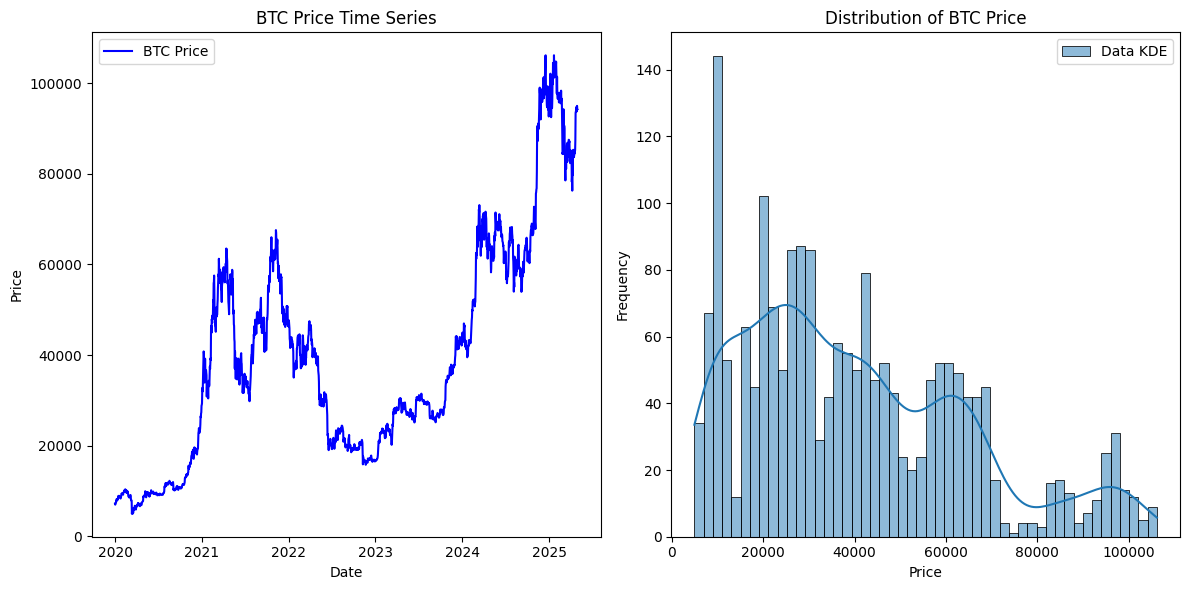

In [5]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 1: Time series of BTC Price
axes[0].plot(BTC_Price, color='blue', label='BTC Price')
axes[0].set_title("BTC Price Time Series")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price")
axes[0].legend()

# Plot 2: Distribution of BTC Price with normal kernel
sns.histplot(BTC_Price, kde=True, ax=axes[1], bins=50, label='Data KDE')
axes[1].set_title("Distribution of BTC Price")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

In [6]:
# Summary statistics
summary_stats = pd.DataFrame(BTC_Price.describe())

# Adding skewness and kurtosis
summary_stats.loc["Skewness"] = BTC_Price.skew()
summary_stats.loc["Kurtosis"] = BTC_Price.kurt()

# Normality test (Shapiro-Wilk)
shapiro_test_stat, shapiro_p_value = shapiro(BTC_Price.dropna())
summary_stats.loc["Shapiro-Wilk p-value"] = shapiro_p_value

# Dropping 25% and 75% rows
summary_stats = summary_stats.drop(["25%", "75%"])

summary_stats = np.round(summary_stats, 4)
summary_stats.T

,count,mean,std,min,50%,max,Skewness,Kurtosis,Shapiro-Wilk p-value
Close,1947.0,39728.0557,24480.5088,4970.7881,35510.2891,106146.2656,0.7355,-0.1557,0.0


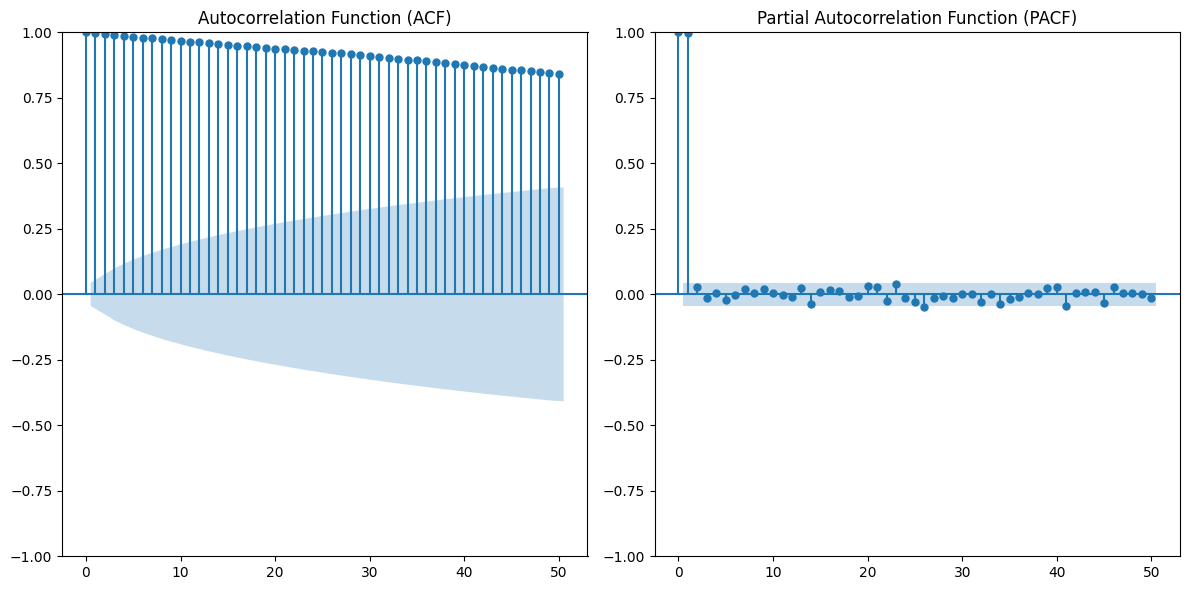

In [7]:
# Create a figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot ACF on the first subplot
plot_acf(BTC_Price, lags=50, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# Plot PACF on the second subplot
plot_pacf(BTC_Price, lags=50, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [8]:
# Perform ADF test on BTC Price (Levels)
adf_result_level = adfuller(BTC_Price)

# Print results for levels
print("ADF Test on Levels (BTC Price):")
print("Null Hypothesis: The series has a unit root (non-stationary).")
print(f"ADF Statistic: {adf_result_level[0]:.4f}")
print(f"p-value: {adf_result_level[1]:.4f}")

# Conclusion based on p-value
if adf_result_level[1] < 0.05:
    print("\nConclusion: Reject the null hypothesis. The series is stationary.")
else:
    print("\nConclusion: Fail to reject the null hypothesis. The series is non-stationary.")

ADF Test on Levels (BTC Price):
Null Hypothesis: The series has a unit root (non-stationary).
ADF Statistic: -0.6803
p-value: 0.8518

Conclusion: Fail to reject the null hypothesis. The series is non-stationary.


## b. Perform the same analysis for a transformed version of the time series that is stationary. To provide arguments about stationarity, you can, for instance, generate visualizations of the time series and use the Augmented Dickey-Fuller (ADF test).

In [9]:
# Calculate log returns
BTC_Log_Returns = np.log(BTC_Price / BTC_Price.shift(1)).dropna()
print(BTC_Log_Returns.size,'\n')
BTC_Log_Returns.info()

1946 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1946 entries, 2020-01-02 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1946 non-null   float64
dtypes: float64(1)
memory usage: 30.4 KB


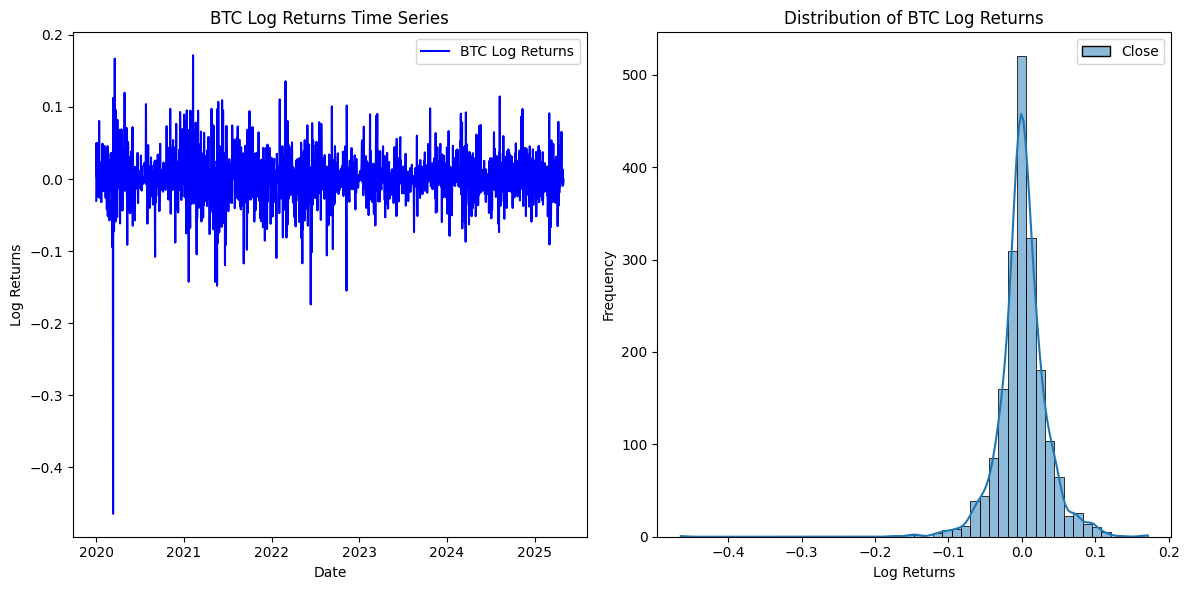

In [10]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 1: Time series of BTC Log Returns
axes[0].plot(BTC_Log_Returns, color='blue', label='BTC Log Returns')
axes[0].set_title("BTC Log Returns Time Series")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Log Returns")
axes[0].legend()

# Plot 2: Distribution of BTC Log Returns
sns.histplot(BTC_Log_Returns, kde=True, ax=axes[1], bins=50)
axes[1].set_title("Distribution of BTC Log Returns")
axes[1].set_xlabel("Log Returns")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [11]:
# Descriptive statistics
summary_stats = BTC_Log_Returns.describe()

# Adding skewness and kurtosis
summary_stats.loc["Skewness"] = BTC_Log_Returns.skew()
summary_stats.loc["Kurtosis"] = BTC_Log_Returns.kurt()

# Normality test (Shapiro-Wilk)
shapiro_stat, shapiro_p_value = shapiro(BTC_Log_Returns.dropna())
#summary_stats.loc["Shapiro-Wilk Statistic"] = shapiro_stat
summary_stats.loc["Shapiro-Wilk p-value"] = shapiro_p_value

# Dropping 25% and 75% rows
summary_stats = summary_stats.drop(["25%", "75%"])

np.round(summary_stats.T, 4)

,count,mean,std,min,50%,max,Skewness,Kurtosis,Shapiro-Wilk p-value
Close,1946.0,0.0013,0.0337,-0.4647,0.0006,0.1718,-1.3525,21.1161,0.0


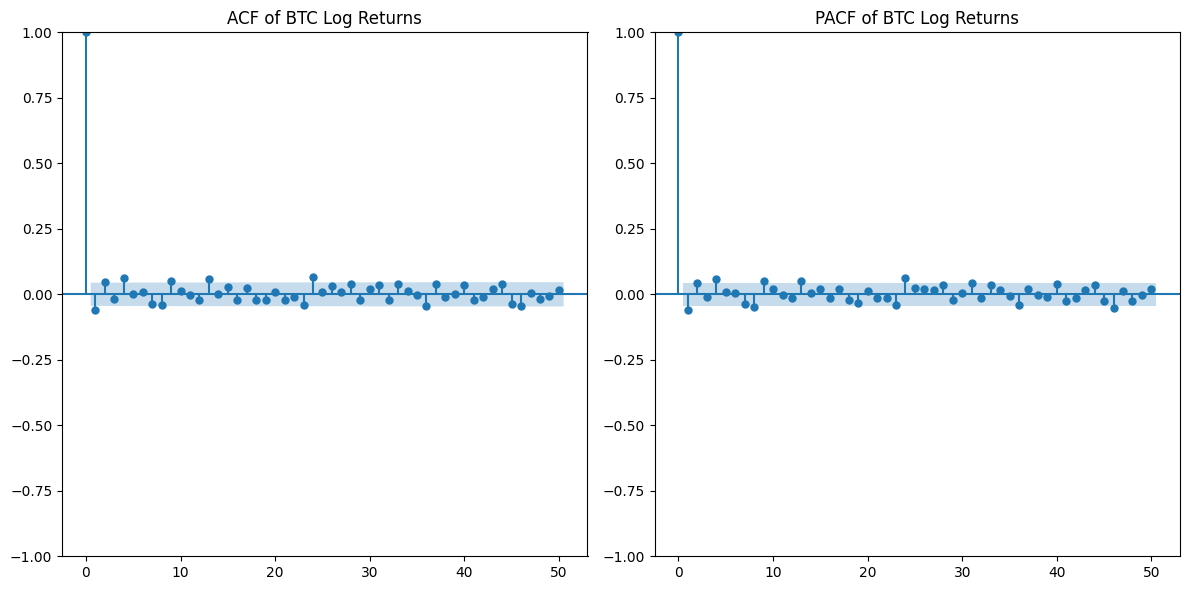

In [12]:
# Create subplots for ACF and PACF
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot ACF
plot_acf(BTC_Log_Returns, lags=50, ax=axes[0])
axes[0].set_title("ACF of BTC Log Returns")

# Plot PACF
plot_pacf(BTC_Log_Returns, lags=50, ax=axes[1])
axes[1].set_title("PACF of BTC Log Returns")

plt.tight_layout()
plt.show()

In [13]:
# Perform ADF test on BTC Log Returns
adf_result_returns = adfuller(BTC_Log_Returns)

# Print ADF test results
print("ADF Test on BTC Log Returns:")
print("Null Hypothesis: The series has a unit root (non-stationary).")
print(f"ADF Statistic: {adf_result_returns[0]:.4f}")
print(f"p-value: {adf_result_returns[1]:.4f}")

# Conclusion
if adf_result_returns[1] < 0.05:
    print("\nConclusion: Reject the null hypothesis. The series is stationary.")
else:
    print("\nConclusion: Fail to reject the null hypothesis. The series is non-stationary.")

ADF Test on BTC Log Returns:
Null Hypothesis: The series has a unit root (non-stationary).
ADF Statistic: -14.4399
p-value: 0.0000

Conclusion: Reject the null hypothesis. The series is stationary.


## c. Use fractional differencing to obtain a new version of the time series that is stationary but retains relevant information about the data. As above, provide a characterization of the main properties of that time series.'

In [14]:
''''
The functions are from the given link:
https://www.kaggle.com/code/elvisesp/time-series-analysis-using-fractional-differencing/notebook
'''

def getWeights(d, lags):
    """
    Compute the weights for fractional differencing.
    Parameters:
        d: Fractional differencing order
        lags: Number of lag coefficients
    Returns:
        weights: Array of weights for fractional differencing
    """
    w = [1]  # Start with initial weight of 1
    for k in range(1, lags):
        w.append(-w[-1] * ((d - k + 1) / k))
    w = np.array(w).reshape(-1, 1)  # Convert to column vector
    return w

def ts_differencing(series, order, lag_cutoff):
    """
    Apply fractional differencing to a time series.
    Parameters:
        series: Original time series
        order: Fractional differencing order
        lag_cutoff: Number of lag coefficients to use
    Returns:
        Fractionally differenced series
    """
    weights = getWeights(order, lag_cutoff)
    diff_series = 0
    for k in range(lag_cutoff):
        diff_series += weights[k] * series.shift(k).fillna(0)  # Apply weights to shifted series
    return diff_series[lag_cutoff:]

In [15]:
# Define the function to evaluate fractional differencing with multiple orders
def evaluate_fractional_differencing(series, d_values, lag_cutoff):
    """
    Test stationarity for multiple fractional differencing orders.
    Parameters:
        series: Original time series
        d_values: List of fractional differencing orders to test
        lag_cutoff: Number of lag coefficients for fractional differencing
    Returns:
        DataFrame: Table with fraction_value, p-value, and conclusion
    """
    results = []

    for d in d_values:
        # Apply fractional differencing
        frac_diff_series = ts_differencing(series, d, lag_cutoff).dropna()

        # Perform ADF test
        adf_result = adfuller(frac_diff_series)
        p_value = adf_result[1]

        # Determine whether to accept or reject the null hypothesis
        conclusion = "Reject" if p_value < 0.05 else "Accept"

        # Append results
        results.append({
            "fraction_value": d,
            "p-value": round(p_value, 4),
            "Conclusion": conclusion
        })

    # Convert results into a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Define the range of fractional values to test
fraction_values = [round(x, 2) for x in np.linspace(0.1, 1.0, 10)]

# Test fractional differencing on the BTC price series
lag_cutoff = 100  # Lag cutoff for fractional differencing
results_df = evaluate_fractional_differencing(BTC_Price, fraction_values, lag_cutoff)

# Display the results table
print(results_df) # Reject means

   fraction_value  p-value Conclusion
0             0.1   0.7726     Accept
1             0.2   0.6269     Accept
2             0.3   0.4756     Accept
3             0.4   0.2052     Accept
4             0.5   0.0382     Reject
5             0.6   0.0020     Reject
6             0.7   0.0001     Reject
7             0.8   0.0000     Reject
8             0.9   0.0000     Reject
9             1.0   0.0000     Reject


In [16]:
# Set parameters
order = 0.6       # Fractional differencing order
lag_cutoff = 100  # Number of lag coefficients to retain

# Apply fractional differencing to the BTC price series
BTC_FracDiff = ts_differencing(BTC_Price, order, lag_cutoff)

# Drop NaN values caused by the differencing
BTC_FracDiff = BTC_FracDiff.dropna()

print(BTC_FracDiff.size,'\n')
BTC_FracDiff.info()

1847 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1847 entries, 2020-04-10 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1847 non-null   float64
dtypes: float64(1)
memory usage: 28.9 KB


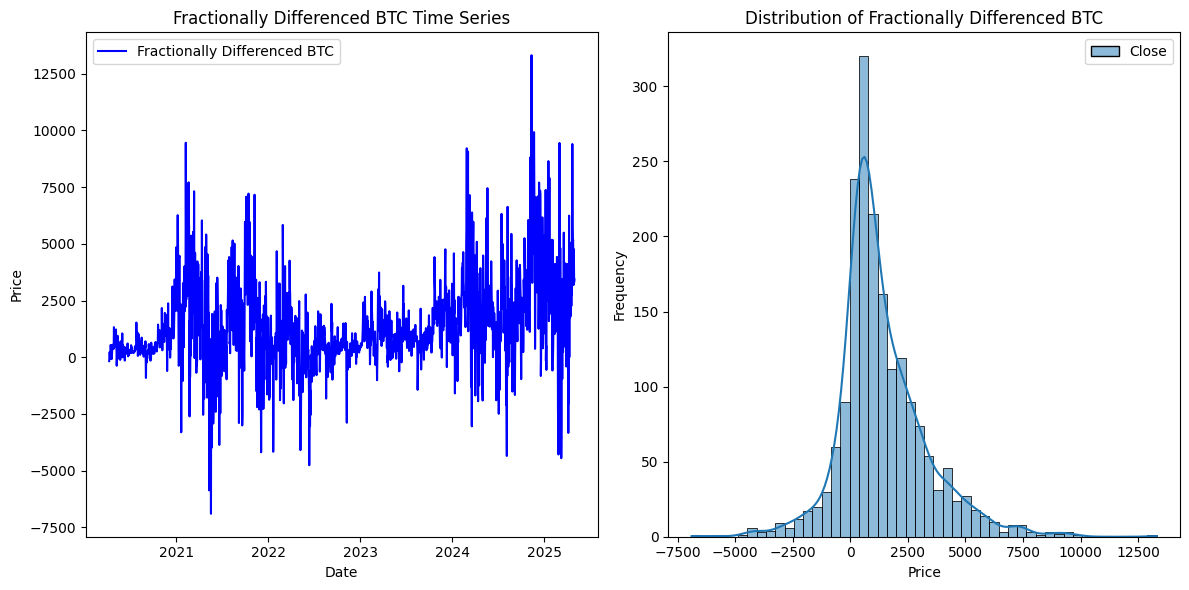

In [17]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot 1: Time series of fractionally differenced BTC
axes[0].plot(BTC_FracDiff, color='blue', label='Fractionally Differenced BTC')
axes[0].set_title("Fractionally Differenced BTC Time Series")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price")
axes[0].legend()

# Plot 2: Distribution of fractionally differenced BTC
sns.histplot(BTC_FracDiff, kde=True, ax=axes[1], bins=50)
axes[1].set_title("Distribution of Fractionally Differenced BTC")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [18]:
# Summary statistics for BTC_FracDiff
summary_stats = pd.DataFrame(BTC_FracDiff.describe())

# Adding skewness and kurtosis
summary_stats.loc["Skewness"] = BTC_FracDiff.skew()
summary_stats.loc["Kurtosis"] = BTC_FracDiff.kurt()

# Normality test (Shapiro-Wilk)
shapiro_stat, shapiro_p_value = shapiro(BTC_FracDiff.dropna())
#summary_stats.loc["Shapiro-Wilk Statistic"] = shapiro_stat
summary_stats.loc["Shapiro-Wilk p-value"] = shapiro_p_value

# Dropping 25% and 75% rows
summary_stats = summary_stats.drop(["25%", "75%"])

summary_stats = np.round(summary_stats, 4).T
summary_stats

,count,mean,std,min,50%,max,Skewness,Kurtosis,Shapiro-Wilk p-value
Close,1847.0,1375.2094,1892.1858,-6898.1094,971.8921,13308.9632,0.9154,3.1389,0.0


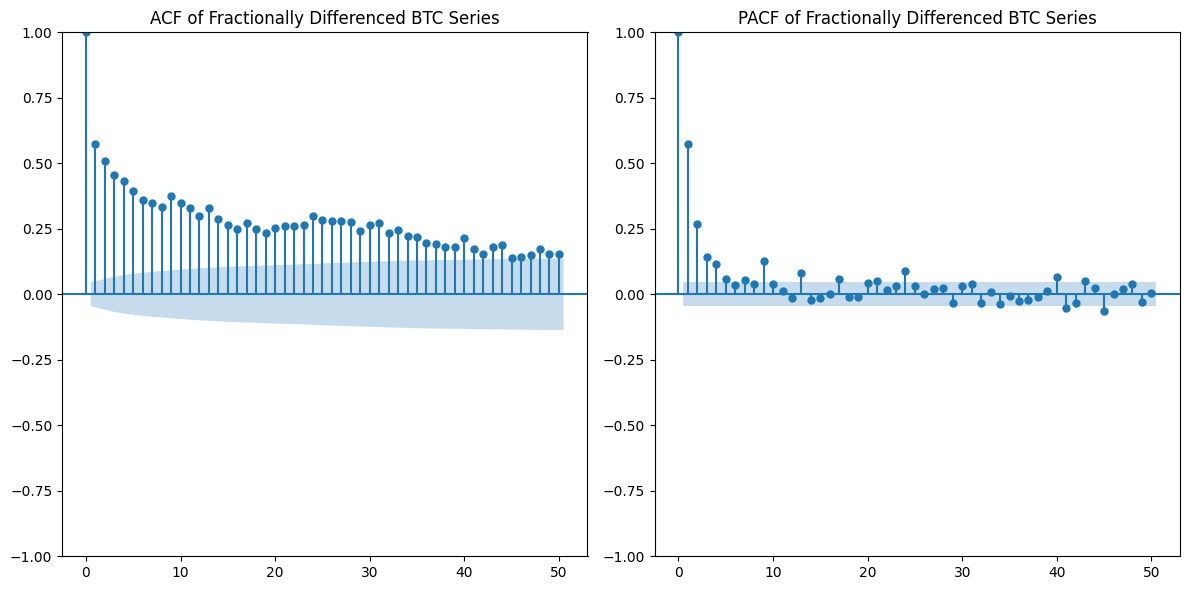

In [19]:
# Create subplots for ACF and PACF
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot ACF
plot_acf(BTC_FracDiff, lags=50, ax=axes[0])
axes[0].set_title("ACF of Fractionally Differenced BTC Series")

# Plot PACF
plot_pacf(BTC_FracDiff, lags=50, ax=axes[1])
axes[1].set_title("PACF of Fractionally Differenced BTC Series")

plt.tight_layout()
plt.show()

In [20]:
# Perform Ljung-Box Test
lb_test = acorr_ljungbox(BTC_FracDiff, lags=30, return_df=True)

# Print Ljung-Box test results
print("Ljung-Box Test Results for Fractionally Differenced BTC Series:")
print("Null Hypothesis: The autocorrelations of the series are zero.")
print("Alternative Hypothesis: The autocorrelations of the series are significantly different from zero.")
print(lb_test)

Ljung-Box Test Results for Fractionally Differenced BTC Series:
Null Hypothesis: The autocorrelations of the series are zero.
Alternative Hypothesis: The autocorrelations of the series are significantly different from zero.
        lb_stat      lb_pvalue
1    611.022627  6.703874e-135
2   1091.484184  9.710039e-238
3   1477.519768   0.000000e+00
4   1823.176417   0.000000e+00
5   2110.348737   0.000000e+00
6   2351.065710   0.000000e+00
7   2577.821894   0.000000e+00
8   2782.821912   0.000000e+00
9   3042.068400   0.000000e+00
10  3269.605567   0.000000e+00
11  3471.847297   0.000000e+00
12  3636.870113   0.000000e+00
13  3841.304091   0.000000e+00
14  3993.956816   0.000000e+00
15  4123.633646   0.000000e+00
16  4240.474059   0.000000e+00
17  4379.393337   0.000000e+00
18  4495.244217   0.000000e+00
19  4597.421909   0.000000e+00
20  4715.549845   0.000000e+00
21  4842.452971   0.000000e+00
22  4969.392810   0.000000e+00
23  5099.171153   0.000000e+00
24  5265.972447   0.000000e+00
2

In [21]:
# Perform ADF test on fractionally differenced BTC series
adf_result_fracdiff = adfuller(BTC_FracDiff)

# Print ADF test results
print("ADF Test on Fractionally Differenced BTC Series:")
print("Null Hypothesis: The series has a unit root (non-stationary).")
print(f"ADF Statistic: {adf_result_fracdiff[0]:.4f}")
print(f"p-value: {adf_result_fracdiff[1]:.4f}")

# Conclusion
if adf_result_fracdiff[1] < 0.05:
    print("Conclusion: Reject the null hypothesis. The series is stationary.")
else:
    print("Conclusion: Fail to reject the null hypothesis. The series is non-stationary.")

ADF Test on Fractionally Differenced BTC Series:
Null Hypothesis: The series has a unit root (non-stationary).
ADF Statistic: -3.9067
p-value: 0.0020
Conclusion: Reject the null hypothesis. The series is stationary.


# Step 2

## a. Using past information of the time series in levels as inputs, build and train an MLP that is designed to predict the level of the time series.

### Data Preparation

In [22]:
file_id = "1yb7pScch7vynLvhPgxZ1rpwRt18F626G"  # Extract file ID from the link
download_url = f"https://drive.google.com/uc?id={file_id}&export=download"

# Read CSV directly from Google Drive link
BTC_Price = pd.read_csv(download_url, parse_dates = ['Date'], index_col = 'Date')
BTC_Price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1947 entries, 2020-01-01 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1947 non-null   float64
dtypes: float64(1)
memory usage: 30.4 KB


In [23]:
# Create lag features using the BTC_Price data
df_BTC_Price = pd.DataFrame(BTC_Price)
df_BTC_Price["Lag30"]   = df_BTC_Price.Close.shift(30)
df_BTC_Price["Lag60"]   = df_BTC_Price.Close.shift(60)
df_BTC_Price["Lag90"]   = df_BTC_Price.Close.shift(90)
df_BTC_Price["Lag120"]  = df_BTC_Price.Close.shift(120)
df_BTC_Price["Lag240"]  = df_BTC_Price.Close.shift(240)
df_BTC_Price["Lag360"]  = df_BTC_Price.Close.shift(360)

# Create target variable: The next 30-day price
df_BTC_Price["Price30"] = df_BTC_Price.Lag30.shift(-30)
df_BTC_Price.dropna(inplace = True)

# Drop the 'Close' column from the DataFrame
df_BTC_Price.drop('Close', axis=1, inplace=True)

# Check the resulting dataset
df_BTC_Price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1557 entries, 2020-12-26 to 2025-03-31
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Lag30    1557 non-null   float64
 1   Lag60    1557 non-null   float64
 2   Lag90    1557 non-null   float64
 3   Lag120   1557 non-null   float64
 4   Lag240   1557 non-null   float64
 5   Lag360   1557 non-null   float64
 6   Price30  1557 non-null   float64
dtypes: float64(7)
memory usage: 97.3 KB


In [24]:
# Train-Test Split
from sklearn.model_selection import train_test_split

# Define input features as lagged price levels
X_Price = df_BTC_Price.iloc[:, :-1]

# Define target variable as future price level
y_Price = df_BTC_Price.iloc[:, -1]

# Define the test size
test_size = 0.3

# Perform train-test split while preserving temporal order
X_Price_train, X_Price_test, y_Price_train, y_Price_test = train_test_split(
    X_Price, y_Price, test_size=test_size, shuffle=False
)

# Check train and test data sizes
print("Train set size (features):", X_Price_train.shape)
print("Test set size (features):", X_Price_test.shape)
print("Train set size (target):", y_Price_train.shape)
print("Test set size (target):", y_Price_test.shape)

Train set size (features): (1089, 6)
Test set size (features): (468, 6)
Train set size (target): (1089,)
Test set size (target): (468,)


In [25]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scalers for price level (X_Price) and target price (y_Price)
scaler_X_Price = MinMaxScaler(feature_range=(-1,1))
scaler_y_Price = MinMaxScaler(feature_range=(-1,1))

# Fit the scalers on training data only
X_Price_train_normalized = scaler_X_Price.fit_transform(X_Price_train)
y_Price_train_normalized = scaler_y_Price.fit_transform(y_Price_train.values.reshape(-1, 1))

# Use the fitted scalers to transform the test data
X_Price_test_normalized = scaler_X_Price.transform(X_Price_test)
y_Price_test_normalized = scaler_y_Price.transform(y_Price_test.values.reshape(-1, 1))

### Hyper-parameter tuning (Use A100 GPU)

In [26]:
import tensorflow as tf
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras import backend as K

if optHPO:
  # Clear session and set seed for replicability
  K.clear_session()
  tf.random.set_seed(1234)

  # Validation split for early stopping
  val_split = 0.2

  # Define the MLP model class with activation function tuning
  class MLP_model(kt.HyperModel):
      def build(self, hp):
          # Tune activation function: choose between ReLU, Sigmoid, and Tanh
          act_fun = hp.Choice("activation", values=["relu", "sigmoid", "tanh"])

          # Tune dropout rate (either 0.2 or 0.3)
          n_dropout = hp.Choice("n_dropout", values=[0.20, 0.30])

          model = tf.keras.models.Sequential()

          # Tune number of hidden layers (1 to 5 layers)
          for i in range(1, hp.Int("num_layers", 1, 5)):
              # Tune number of units per layer (1 to 25 with step size of 5)
              model.add(
                  tf.keras.layers.Dense(
                      units=hp.Int(
                          "units_dense_" + str(i), min_value=1, max_value=25, step=5
                      ),
                      activation=act_fun,  # Use tuned activation function
                  )
              )
              model.add(tf.keras.layers.Dropout(n_dropout))  # Add dropout layer

          # Final output layer for regression
          model.add(tf.keras.layers.Dense(units=1, activation="linear"))

          model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="mean_absolute_error"
          )
          return model

  # Initialize the Hyperband tuner
  tuner = kt.Hyperband(
      MLP_model(),
      objective=kt.Objective("val_loss", direction="min"),
      overwrite=True,
      max_epochs=100,
      seed=1234,
  )

  # Define EarlyStopping callback
  early_stopping = EarlyStopping(
      monitor="val_loss",  # Monitor validation loss
      mode="min",  # Stop when validation loss is minimized
      patience=10,  # Number of epochs to wait without improvement
      restore_best_weights=True,  # Restore model weights from the best epoch
      verbose=1,  # Display early stopping info
  )

  # Perform hyperparameter tuning with EarlyStopping
  tuner.search(
      X_Price_train_normalized,
      y_Price_train_normalized,
      validation_split=val_split,
      epochs=100,
      batch_size=32,
      verbose=1,
      callbacks=[early_stopping],  # Add EarlyStopping callback
  )

  # Retrieve the best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  print("Best Hyperparameters:", best_hps.values)

Trial 254 Complete [00h 00m 23s]
val_loss: 0.26681604981422424

Best val_loss So Far: 0.09234440326690674
Total elapsed time: 00h 19m 12s

Best Hyperparameters: {'activation': 'tanh', 'n_dropout': 0.2, 'num_layers': 3, 'units_dense_1': 21, 'units_dense_2': 6, 'units_dense_3': 6, 'units_dense_4': 6, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}

### Model Training

In [27]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping

# Set TensorFlow seed
tf.random.set_seed(42)

# Clear session to reset the state
K.clear_session()

# Define the model for price-level prediction (`model_price`)
model_price = tf.keras.models.Sequential()

# Add the first hidden layer
model_price.add(tf.keras.layers.Dense(units=21, activation="sigmoid"))
model_price.add(tf.keras.layers.Dropout(0.2))

# Add the second hidden layer
model_price.add(tf.keras.layers.Dense(units=6, activation="tanh"))
model_price.add(tf.keras.layers.Dropout(0.2))

# Add the third hidden layer
model_price.add(tf.keras.layers.Dense(units=6, activation="tanh"))
model_price.add(tf.keras.layers.Dropout(0.2))

# Add the output layer (linear activation for regression)
model_price.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Compile the model
model_price.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="mean_absolute_error"
)

# Define EarlyStopping callback
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=0,
    patience=20,
    restore_best_weights=True
)

# Train the `model_price` model
history_price = model_price.fit(
    X_Price_train_normalized,
    y_Price_train_normalized,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=0,
    callbacks=[es]
)

print("Model training for price data (`model_price`) completed successfully!")

Model training for price data (`model_price`) completed successfully!


In [28]:
model_price.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           147 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 986 (3.86 KB)

 Trainable params: 328 (1.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 658 (2.57 KB)

### Performance Evaluation

In [29]:
# Evaluate the model on the training set for price data
y_train_pred_price = model_price.predict(X_Price_train_normalized)
y_train_actual_price = y_Price_train_normalized

# Evaluate the model on the test set for price data
y_test_pred_price = model_price.predict(X_Price_test_normalized)
y_test_actual_price = y_Price_test_normalized

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE for the training set
train_mae_price = mean_absolute_error(y_train_actual_price, y_train_pred_price)
train_rmse_price = np.sqrt(mean_squared_error(y_train_actual_price, y_train_pred_price))

# Calculate MAE and RMSE for the test set
test_mae_price = mean_absolute_error(y_test_actual_price, y_test_pred_price)
test_rmse_price = np.sqrt(mean_squared_error(y_test_actual_price, y_test_pred_price))

# Create a DataFrame with the evaluation metrics
performance_data_price = {
    "Metric": ["MAE", "RMSE"],  # Metrics to evaluate
    "Training": [train_mae_price, train_rmse_price],  # Training set metrics
    "Testing": [test_mae_price, test_rmse_price],  # Test set metrics
}

performance_df_price = pd.DataFrame(performance_data_price)

# Display the DataFrame
print("Model Performance for Price-Level Prediction:")
np.round(performance_df_price, 4)

Model Performance for Price-Level Prediction:


,Metric,Training,Testing
0,MAE,0.3385,1.0446
1,RMSE,0.4472,1.1503


## b. Using past information of the stationary time series as inputs, build and train an MLP that is designed to predict the stationary version of the time series.

### Data Preparation

In [31]:
file_id = "1yb7pScch7vynLvhPgxZ1rpwRt18F626G"  # Extract file ID from the link
download_url = f"https://drive.google.com/uc?id={file_id}&export=download"

# Read CSV directly from Google Drive link
BTC_Price = pd.read_csv(download_url, parse_dates = ['Date'], index_col = 'Date')
BTC_Price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1947 entries, 2020-01-01 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1947 non-null   float64
dtypes: float64(1)
memory usage: 30.4 KB


In [32]:
# Log return computation
BTC_Log_Return = np.log(BTC_Price / BTC_Price.shift(1))

# Rename column from "Close" to "LogReturn"
BTC_Log_Return.rename(columns={"Close": "LogReturn"}, inplace=True)
BTC_Log_Return.dropna(inplace=True)

BTC_Log_Return.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1946 entries, 2020-01-02 to 2025-04-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LogReturn  1946 non-null   float64
dtypes: float64(1)
memory usage: 30.4 KB


In [33]:
# Create the DataFrame using BTC_Log_Return, ensuring column name "LogReturn"
df_BTC_Log_Return = pd.DataFrame(BTC_Log_Return, columns=["LogReturn"])

# Define the lambda function to calculate cumulative log return by summing
# This gives the total log return over the window (ln(Pn/P0))
calculate_cumulative_log_return = lambda x: x.sum()

# Generate accumulated returns for rolling windows of 30, 60, 90, 120, 240, and 360 days
df_BTC_Log_Return["LogRet30_i"] = df_BTC_Log_Return["LogReturn"].rolling(30).apply(calculate_cumulative_log_return, raw=True)
df_BTC_Log_Return["LogRet60_i"] = df_BTC_Log_Return["LogReturn"].rolling(60).apply(calculate_cumulative_log_return, raw=True)
df_BTC_Log_Return["LogRet90_i"] = df_BTC_Log_Return["LogReturn"].rolling(90).apply(calculate_cumulative_log_return, raw=True)
df_BTC_Log_Return["LogRet120_i"] = df_BTC_Log_Return["LogReturn"].rolling(120).apply(calculate_cumulative_log_return, raw=True)
df_BTC_Log_Return["LogRet240_i"] = df_BTC_Log_Return["LogReturn"].rolling(240).apply(calculate_cumulative_log_return, raw=True)
df_BTC_Log_Return["LogRet360_i"] = df_BTC_Log_Return["LogReturn"].rolling(360).apply(calculate_cumulative_log_return, raw=True)

# Shift the target variable (Ret30)
# The target variable 'LogRet30' now represents the cumulative log return over the next 30 days
df_BTC_Log_Return["Ret30"] = df_BTC_Log_Return["LogRet30_i"].shift(-30)
df_BTC_Log_Return.drop('LogReturn', axis= 1, inplace = True)

# Drop rows with missing values resulting from rolling and shifting
df_BTC_Log_Return.dropna(inplace=True)

# Display resulting DataFrame info
df_BTC_Log_Return.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1557 entries, 2020-12-26 to 2025-03-31
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LogRet30_i   1557 non-null   float64
 1   LogRet60_i   1557 non-null   float64
 2   LogRet90_i   1557 non-null   float64
 3   LogRet120_i  1557 non-null   float64
 4   LogRet240_i  1557 non-null   float64
 5   LogRet360_i  1557 non-null   float64
 6   Ret30        1557 non-null   float64
dtypes: float64(7)
memory usage: 97.3 KB


In [34]:
from sklearn.model_selection import train_test_split

# Define input features as lagged log returns
X_LogReturn = df_BTC_Log_Return.iloc[:, :-1]  # Not included current log return

# Define target variable as future log return
y_LogReturn = df_BTC_Log_Return.iloc[:, -1]  # The last column, Ret30 (Total current accumulate 30-day return)

# Define the test size (30% for testing)
test_size = 0.3

# Perform train-test split while preserving temporal order
X_LogReturn_train, X_LogReturn_test, y_LogReturn_train, y_LogReturn_test = train_test_split(
    X_LogReturn, y_LogReturn, test_size=test_size, shuffle=False
)

# Check train and test data sizes
print("Train set size (features):", X_LogReturn_train.shape)
print("Test set size (features):", X_LogReturn_test.shape)
print("Train set size (target):", y_LogReturn_train.shape)
print("Test set size (target):", y_LogReturn_test.shape)

Train set size (features): (1089, 6)
Test set size (features): (468, 6)
Train set size (target): (1089,)
Test set size (target): (468,)


In [35]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scalers for input features (X_LogReturn) and target variable (y_LogReturn)
scaler_X_LogReturn = MinMaxScaler(feature_range= (-1,1))
scaler_y_LogReturn = MinMaxScaler(feature_range= (-1,1))

# Fit the scalers on training data only
X_LogReturn_train_normalized = scaler_X_LogReturn.fit_transform(X_LogReturn_train)
y_LogReturn_train_normalized = scaler_y_LogReturn.fit_transform(y_LogReturn_train.values.reshape(-1, 1))

# Use the fitted scalers to transform the test data
X_LogReturn_test_normalized = scaler_X_LogReturn.transform(X_LogReturn_test)
y_LogReturn_test_normalized = scaler_y_LogReturn.transform(y_LogReturn_test.values.reshape(-1, 1))

# Verify the shapes of the normalized data
print("Normalized Training Set (Features):", X_LogReturn_train_normalized.shape)
print("Normalized Test Set (Features):", X_LogReturn_test_normalized.shape)
print("Normalized Training Set (Target):", y_LogReturn_train_normalized.shape)
print("Normalized Test Set (Target):", y_LogReturn_test_normalized.shape)

Normalized Training Set (Features): (1089, 6)
Normalized Test Set (Features): (468, 6)
Normalized Training Set (Target): (1089, 1)
Normalized Test Set (Target): (468, 1)


### Hyper-parameter tuning (Use A100 GPU)

In [36]:
import tensorflow as tf
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras import backend as K

if optHPO:
  # Clear session and set seed for replicability
  K.clear_session()
  tf.random.set_seed(1234)

  # Validation split for early stopping
  val_split = 0.2

  # Define the MLP model class with activation function tuning
  class MLP_LogReturn_Model(kt.HyperModel):
      def build(self, hp):
          # Tune activation function: choose between ReLU, Sigmoid, and Tanh
          act_fun = hp.Choice("activation", values=["relu", "sigmoid", "tanh"])

          # Tune dropout rate (either 0.2 or 0.3)
          n_dropout = hp.Choice("n_dropout", values=[0.20, 0.30])

          model = tf.keras.models.Sequential()

          # Tune number of hidden layers (1 to 5 layers)
          for i in range(1, hp.Int("num_layers", 1, 5)):
              # Tune number of units per layer (1 to 25 with step size of 5)
              model.add(
                  tf.keras.layers.Dense(
                      units=hp.Int(
                          "units_dense_" + str(i), min_value=1, max_value=25, step=5
                      ),
                      activation=act_fun,  # Use tuned activation function
                  )
              )
              model.add(tf.keras.layers.Dropout(n_dropout))  # Add dropout layer

          # Final output layer for regression
          model.add(tf.keras.layers.Dense(units=1, activation="linear"))

          model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="mean_absolute_error"  # Regression loss
          )
          return model

  # Initialize the Hyperband tuner
  tuner = kt.Hyperband(
      MLP_LogReturn_Model(),
      objective=kt.Objective("val_loss", direction="min"),
      overwrite=True,
      max_epochs=100,
      seed=1234,
  )

  # Define EarlyStopping callback
  early_stopping = EarlyStopping(
      monitor="val_loss",
      mode="min",
      patience=10,
      restore_best_weights=True,
      verbose=1,
  )

  # Perform hyperparameter tuning with EarlyStopping
  tuner.search(
      X_LogReturn_train_normalized,
      y_LogReturn_train_normalized,
      validation_split=val_split,
      epochs=100,
      batch_size=32,
      verbose=1,
      callbacks=[early_stopping],
  )

  # Retrieve the best hyperparameters
  best_hps_log_return = tuner.get_best_hyperparameters(num_trials=1)[0]
  print("Best Hyperparameters for Log Return Model:", best_hps_log_return.values)

Trial 254 Complete [00h 00m 12s]
val_loss: 0.18962933123111725

Best val_loss So Far: 0.15474821627140045
Total elapsed time: 00h 34m 22s

Best Hyperparameters for Log Return Model: {'activation': 'tanh', 'n_dropout': 0.3, 'num_layers': 2, 'units_dense_1': 16, 'units_dense_2': 16, 'units_dense_3': 6, 'units_dense_4': 16, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}

### Model Training

In [37]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping

# Set TensorFlow seed
tf.random.set_seed(42)

# Clear session to reset the state
K.clear_session()

# Define the model for log return prediction (`model_log_return`)
model_log_return = tf.keras.models.Sequential()

# Add the first hidden layer with 6 units and sigmoid activation
model_log_return.add(tf.keras.layers.Dense(units=16, activation="tanh"))
model_log_return.add(tf.keras.layers.Dropout(0.2))

# Add the second hidden layer with 16 units and sigmoid activation
model_log_return.add(tf.keras.layers.Dense(units=16, activation="tanh"))
model_log_return.add(tf.keras.layers.Dropout(0.2))

# Add the output layer (linear activation for regression)
model_log_return.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Compile the model
model_log_return.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="mean_absolute_error"
)

# Define EarlyStopping callback
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=20,
    restore_best_weights=True
)

# Train the `model_log_return` model
history_log_return = model_log_return.fit(
    X_LogReturn_train_normalized,
    y_LogReturn_train_normalized,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=0,
    callbacks=[es]
)

print("Model training for log return data (`model_log_return`) completed successfully!")

Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 10.
Model training for log return data (`model_log_return`) completed successfully!


In [38]:
model_log_return.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205 (4.71 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 804 (3.14 KB)

### Performance Evaluation

In [39]:
# Evaluate the model on the training set for log return data
y_train_pred_log_return = model_log_return.predict(X_LogReturn_train_normalized)
y_train_actual_log_return = y_LogReturn_train_normalized

# Evaluate the model on the test set for log return data
y_test_pred_log_return = model_log_return.predict(X_LogReturn_test_normalized)
y_test_actual_log_return = y_LogReturn_test_normalized

# Verify the shapes of the predictions and actual values
print("Train set predictions shape:", y_train_pred_log_return.shape)
print("Train set actual values shape:", y_train_actual_log_return.shape)
print("Test set predictions shape:", y_test_pred_log_return.shape)
print("Test set actual values shape:", y_test_actual_log_return.shape)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train set predictions shape: (1089, 1)
Train set actual values shape: (1089, 1)
Test set predictions shape: (468, 1)
Test set actual values shape: (468, 1)


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE for the training set
train_mae_log_return = mean_absolute_error(y_train_actual_log_return, y_train_pred_log_return)
train_rmse_log_return = np.sqrt(mean_squared_error(y_train_actual_log_return, y_train_pred_log_return))

# Calculate MAE and RMSE for the test set
test_mae_log_return = mean_absolute_error(y_test_actual_log_return, y_test_pred_log_return)
test_rmse_log_return = np.sqrt(mean_squared_error(y_test_actual_log_return, y_test_pred_log_return))

# Create a DataFrame with the evaluation metrics
performance_data_log_return = {
    "Metric": ["MAE", "RMSE"],  # Metrics to evaluate
    "Training": [train_mae_log_return, train_rmse_log_return],  # Training set metrics
    "Testing": [test_mae_log_return, test_rmse_log_return],  # Test set metrics
}

performance_df_log_return = pd.DataFrame(performance_data_log_return)

# Display the DataFrame
print("Model Performance for Log Return Prediction:")
np.round(performance_df_log_return,4)

Model Performance for Log Return Prediction:


,Metric,Training,Testing
0,MAE,0.2708,0.1967
1,RMSE,0.3374,0.2634


## c. Using past information of the fractionally differenced time series as inputs, build and train an MLP that is designed to predict the fractionally-differenced version of the time series.

### Data Preparation

In [41]:
file_id = "1yb7pScch7vynLvhPgxZ1rpwRt18F626G"  # Extract file ID from the link
download_url = f"https://drive.google.com/uc?id={file_id}&export=download"

# Read CSV directly from Google Drive link
BTC_Price = pd.read_csv(download_url, parse_dates = ['Date'], index_col = 'Date')
BTC_Price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1947 entries, 2020-01-01 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1947 non-null   float64
dtypes: float64(1)
memory usage: 30.4 KB


In [42]:
def getWeights(d, lags):
    """
    Compute the weights for fractional differencing.
    Parameters:
        d: Fractional differencing order
        lags: Number of lag coefficients
    Returns:
        weights: Array of weights for fractional differencing
    """
    w = [1]  # Start with initial weight of 1
    for k in range(1, lags):
        w.append(-w[-1] * ((d - k + 1) / k))
    w = np.array(w).reshape(-1, 1)  # Convert to column vector
    return w


def ts_differencing(series, order, lag_cutoff):
    """
    Apply fractional differencing to a time series.
    Parameters:
        series: Original time series
        order: Fractional differencing order
        lag_cutoff: Number of lag coefficients to use
    Returns:
        Fractionally differenced series
    """
    weights = getWeights(order, lag_cutoff)  # Compute weights
    diff_series = 0
    for k in range(lag_cutoff):
        diff_series += weights[k] * series.shift(k).fillna(0)  # Apply weights to shifted series
    return diff_series[lag_cutoff:]  # Drop initial NaN values

# Apply fractional differencing to the BTC price series
order = 0.6  # Fractional differencing order
lag_cutoff = 100  # Number of lag coefficients to retain

BTC_FracDiff = ts_differencing(BTC_Price, order, lag_cutoff)

# Drop NaN values caused by the differencing
BTC_FracDiff = BTC_FracDiff.dropna()

BTC_FracDiff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1847 entries, 2020-04-10 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1847 non-null   float64
dtypes: float64(1)
memory usage: 28.9 KB


In [43]:
# Create lag features using the fractionally differenced BTC price data
df_BTC_FracDiff = pd.DataFrame(BTC_FracDiff)

df_BTC_FracDiff["Lag30"]   = df_BTC_FracDiff["Close"].shift(30)
df_BTC_FracDiff["Lag60"]   = df_BTC_FracDiff["Close"].shift(60)
df_BTC_FracDiff["Lag90"]   = df_BTC_FracDiff["Close"].shift(90)
df_BTC_FracDiff["Lag120"]  = df_BTC_FracDiff["Close"].shift(120)
df_BTC_FracDiff["Lag240"]  = df_BTC_FracDiff["Close"].shift(240)
df_BTC_FracDiff["Lag360"]  = df_BTC_FracDiff["Close"].shift(360)

# Create target variable
df_BTC_FracDiff["Price30"] = df_BTC_FracDiff["Lag30"].shift(-30)

# Drop rows with missing values
df_BTC_FracDiff.dropna(inplace=True)

# Drop the original 'FracDiff' column (optional)
df_BTC_FracDiff.drop('Close', axis=1, inplace=True)
df_BTC_FracDiff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1457 entries, 2021-04-05 to 2025-03-31
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Lag30    1457 non-null   float64
 1   Lag60    1457 non-null   float64
 2   Lag90    1457 non-null   float64
 3   Lag120   1457 non-null   float64
 4   Lag240   1457 non-null   float64
 5   Lag360   1457 non-null   float64
 6   Price30  1457 non-null   float64
dtypes: float64(7)
memory usage: 91.1 KB


In [44]:
from sklearn.model_selection import train_test_split

# Define input features from the fractionally differenced BTC price data
X_FracDiff = df_BTC_FracDiff.iloc[:, :-1]  # Exclude the last column (target variable)

# Define target variable as future price level
y_FracDiff = df_BTC_FracDiff.iloc[:, -1]  # Only the last column (target variable)

# Define the test size (e.g., 30% test data)
test_size = 0.3

# Perform train-test split while preserving temporal order
X_FracDiff_train, X_FracDiff_test, y_FracDiff_train, y_FracDiff_test = train_test_split(
    X_FracDiff, y_FracDiff, test_size=test_size, shuffle=False
)

# Check train and test data sizes
print("Train set size (features):", X_FracDiff_train.shape)
print("Test set size (features):", X_FracDiff_test.shape)
print("Train set size (target):", y_FracDiff_train.shape)
print("Test set size (target):", y_FracDiff_test.shape)

Train set size (features): (1019, 6)
Test set size (features): (438, 6)
Train set size (target): (1019,)
Test set size (target): (438,)


In [45]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scalers for fractionally differenced data (X_FracDiff) and target price (y_FracDiff)
scaler_X_FracDiff = MinMaxScaler(feature_range= (-1,1))
scaler_y_FracDiff = MinMaxScaler(feature_range= (-1,1))

# Fit the scalers on training data only
X_FracDiff_train_normalized = scaler_X_FracDiff.fit_transform(X_FracDiff_train)
y_FracDiff_train_normalized = scaler_y_FracDiff.fit_transform(y_FracDiff_train.values.reshape(-1, 1))

# Use the fitted scalers to transform the test data
X_FracDiff_test_normalized = scaler_X_FracDiff.transform(X_FracDiff_test)
y_FracDiff_test_normalized = scaler_y_FracDiff.transform(y_FracDiff_test.values.reshape(-1, 1))

# Display the resulting dimensions for confirmation
print("Train set size (normalized features):", X_FracDiff_train_normalized.shape)
print("Test set size (normalized features):", X_FracDiff_test_normalized.shape)
print("Train set size (normalized target):", y_FracDiff_train_normalized.shape)
print("Test set size (normalized target):", y_FracDiff_test_normalized.shape)

Train set size (normalized features): (1019, 6)
Test set size (normalized features): (438, 6)
Train set size (normalized target): (1019, 1)
Test set size (normalized target): (438, 1)


### Hyper-parameter tuning (Use A100 GPU)

In [46]:
import tensorflow as tf
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras import backend as K

if optHPO:
  # Clear session and set seed for replicability
  K.clear_session()
  tf.random.set_seed(1234)

  # Validation split for early stopping
  val_split = 0.2

  # Define the MLP model class with activation function tuning
  class MLP_model(kt.HyperModel):
      def build(self, hp):
          # Tune activation function: choose between ReLU, Sigmoid, and Tanh
          act_fun = hp.Choice("activation", values=["relu", "sigmoid", "tanh"])

          # Tune dropout rate (either 0.2 or 0.3)
          n_dropout = hp.Choice("n_dropout", values=[0.20, 0.30])

          model = tf.keras.models.Sequential()

          # Tune number of hidden layers (1 to 5 layers)
          for i in range(1, hp.Int("num_layers", 1, 5)):
              # Tune number of units per layer (1 to 25 with step size of 5)
              model.add(
                  tf.keras.layers.Dense(
                      units=hp.Int(
                          "units_dense_" + str(i), min_value=1, max_value=25, step=5
                      ),
                      activation=act_fun,  # Use tuned activation function
                  )
              )
              model.add(tf.keras.layers.Dropout(n_dropout))  # Add dropout layer

          # Final output layer for regression
          model.add(tf.keras.layers.Dense(units=1, activation="linear"))

          model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="mean_absolute_error"
          )
          return model

  # Initialize the Hyperband tuner
  tuner = kt.Hyperband(
      MLP_model(),
      objective=kt.Objective("val_loss", direction="min"),
      overwrite=True,
      max_epochs=100,
      seed=1234,
  )

  # Define EarlyStopping callback
  early_stopping = EarlyStopping(
      monitor="val_loss",
      mode="min",
      patience=10,
      restore_best_weights=True,
      verbose=1,
  )

  # Perform hyperparameter tuning with EarlyStopping
  tuner.search(
      X_FracDiff_train_normalized,
      y_FracDiff_train_normalized,
      validation_split=val_split,
      epochs=100,
      batch_size=32,
      verbose=1,
      callbacks=[early_stopping],
  )

  # Retrieve the best hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  print("Best Hyperparameters:", best_hps.values)

Trial 254 Complete [00h 00m 16s]
val_loss: 0.13024811446666718

Best val_loss So Far: 0.09976538270711899
Total elapsed time: 00h 50m 55s

Best Hyperparameters: {'activation': 'sigmoid', 'n_dropout': 0.2, 'num_layers': 4, 'units_dense_1': 16, 'units_dense_2': 21, 'units_dense_3': 1, 'units_dense_4': 16, 'tuner/epochs': 100, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


### Model Training

In [47]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping

# Set TensorFlow seed
tf.random.set_seed(42)

# Clear session to reset the state
K.clear_session()

# Define the model for fractionally differenced data prediction (`model_frac_diff`)
model_frac_diff = tf.keras.models.Sequential()

# Add the first hidden layer
model_frac_diff.add(tf.keras.layers.Dense(units=16, activation="sigmoid"))
model_frac_diff.add(tf.keras.layers.Dropout(0.2))

# Add the second hidden layer
model_frac_diff.add(tf.keras.layers.Dense(units=21, activation="sigmoid"))
model_frac_diff.add(tf.keras.layers.Dropout(0.2))

# Add the third hidden layer
model_frac_diff.add(tf.keras.layers.Dense(units=16, activation="sigmoid"))
model_frac_diff.add(tf.keras.layers.Dropout(0.2))

# Add the fourth hidden layer
model_frac_diff.add(tf.keras.layers.Dense(units=16, activation="sigmoid"))
model_frac_diff.add(tf.keras.layers.Dropout(0.2))

# Add the output layer (linear activation for regression)
model_frac_diff.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Compile the model
model_frac_diff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="mean_absolute_error"
)

# Define EarlyStopping callback
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=0,
    patience=20,
    restore_best_weights=True
)

# Train the `model_frac_diff` model
history_frac_diff = model_frac_diff.fit(
    X_FracDiff_train_normalized,
    y_FracDiff_train_normalized,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    verbose=0,
    callbacks=[es]
)

print("Model training for fractionally differenced data (`model_frac_diff`) completed successfully!")

Model training for fractionally differenced data (`model_frac_diff`) completed successfully!


In [48]:
model_frac_diff.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │           357 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,332 (13.02 KB)

 Trainable params: 1,110 (4.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,222 (8.68 KB)

### Performance Evaluation

In [49]:
# Evaluate the model on the training set for fractionally differenced data
y_train_pred_frac_diff = model_frac_diff.predict(X_FracDiff_train_normalized)
y_train_actual_frac_diff = y_FracDiff_train_normalized

# Evaluate the model on the test set for fractionally differenced data
y_test_pred_frac_diff = model_frac_diff.predict(X_FracDiff_test_normalized)
y_test_actual_frac_diff = y_FracDiff_test_normalized

# Print the dimensions of the predictions and actual values to confirm
print("Train set predictions shape:", y_train_pred_frac_diff.shape)
print("Train set actual values shape:", y_train_actual_frac_diff.shape)
print("Test set predictions shape:", y_test_pred_frac_diff.shape)
print("Test set actual values shape:", y_test_actual_frac_diff.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train set predictions shape: (1019, 1)
Train set actual values shape: (1019, 1)
Test set predictions shape: (438, 1)
Test set actual values shape: (438, 1)


In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE for the training set
train_mae_frac_diff = mean_absolute_error(y_train_actual_frac_diff, y_train_pred_frac_diff)
train_rmse_frac_diff = np.sqrt(mean_squared_error(y_train_actual_frac_diff, y_train_pred_frac_diff))

# Calculate MAE and RMSE for the test set
test_mae_frac_diff = mean_absolute_error(y_test_actual_frac_diff, y_test_pred_frac_diff)
test_rmse_frac_diff = np.sqrt(mean_squared_error(y_test_actual_frac_diff, y_test_pred_frac_diff))

# Create a DataFrame with the evaluation metrics
performance_data_frac_diff = {
    "Metric": ["MAE", "RMSE"],  # Metrics to evaluate
    "Training": [train_mae_frac_diff, train_rmse_frac_diff],  # Training set metrics
    "Testing": [test_mae_frac_diff, test_rmse_frac_diff],  # Test set metrics
}

performance_df_frac_diff = pd.DataFrame(performance_data_frac_diff)

# Display the DataFrame
print("Model Performance for Fractionally Differenced Data Prediction:")
np.round(performance_df_frac_diff, 4)

Model Performance for Fractionally Differenced Data Prediction:


,Metric,Training,Testing
0,MAE,0.147,0.3209
1,RMSE,0.213,0.4174


# Step 3

## a. Using the GAF representation of the time series in levels, build and train a CNN that is designed to predict the level of the time series.

### Data Preparation

In [51]:
file_id = "1yb7pScch7vynLvhPgxZ1rpwRt18F626G"  # Extract file ID from the link
download_url = f"https://drive.google.com/uc?id={file_id}&export=download"

# Read CSV directly from Google Drive link
BTC_Price = pd.read_csv(download_url, parse_dates = ['Date'], index_col = 'Date')
BTC_Price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1947 entries, 2020-01-01 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1947 non-null   float64
dtypes: float64(1)
memory usage: 30.4 KB


In [52]:
# Create lag features using the BTC_Price data
df_BTC_Price = pd.DataFrame(BTC_Price)
df_BTC_Price["Lag30"]   = df_BTC_Price.Close.shift(30)
df_BTC_Price["Lag60"]   = df_BTC_Price.Close.shift(60)
df_BTC_Price["Lag90"]   = df_BTC_Price.Close.shift(90)
df_BTC_Price["Lag120"]  = df_BTC_Price.Close.shift(120)
df_BTC_Price["Lag240"]  = df_BTC_Price.Close.shift(240)
df_BTC_Price["Lag360"]  = df_BTC_Price.Close.shift(360)

# Create target variable: The next 30-day price
df_BTC_Price["Price30"] = df_BTC_Price.Lag30.shift(-30)
df_BTC_Price.dropna(inplace = True)

# Drop the 'Close' column from the DataFrame
df_BTC_Price.drop('Close', axis=1, inplace=True)

# Check the resulting dataset
df_BTC_Price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1557 entries, 2020-12-26 to 2025-03-31
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Lag30    1557 non-null   float64
 1   Lag60    1557 non-null   float64
 2   Lag90    1557 non-null   float64
 3   Lag120   1557 non-null   float64
 4   Lag240   1557 non-null   float64
 5   Lag360   1557 non-null   float64
 6   Price30  1557 non-null   float64
dtypes: float64(7)
memory usage: 97.3 KB


In [53]:
# Train-Test Split
from sklearn.model_selection import train_test_split

# Define input features as lagged price levels
X_Price = df_BTC_Price.iloc[:, :-1]

# Define target variable as future price level
y_Price = df_BTC_Price.iloc[:, -1]

# Define the test size
test_size = 0.3

# Perform train-test split while preserving temporal order
X_Price_train, X_Price_test, y_Price_train, y_Price_test = train_test_split(
    X_Price, y_Price, test_size=test_size, shuffle=False
)

# Check train and test data sizes
print("Train set size (features):", X_Price_train.shape)
print("Test set size (features):", X_Price_test.shape)
print("Train set size (target):", y_Price_train.shape)
print("Test set size (target):", y_Price_test.shape)

Train set size (features): (1089, 6)
Test set size (features): (468, 6)
Train set size (target): (1089,)
Test set size (target): (468,)


In [54]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scalers for price level (X_Price) and target price (y_Price)
scaler_X_Price = MinMaxScaler(feature_range = (-1,1))
scaler_y_Price = MinMaxScaler(feature_range = (-1,1))

# Fit the scalers on training data only
X_Price_train_normalized = scaler_X_Price.fit_transform(X_Price_train)
y_Price_train_normalized = scaler_y_Price.fit_transform(y_Price_train.values.reshape(-1, 1))

# Use the fitted scalers to transform the test data
X_Price_test_normalized = scaler_X_Price.transform(X_Price_test)
y_Price_test_normalized = scaler_y_Price.transform(y_Price_test.values.reshape(-1, 1))

In [55]:
from pyts.image import GramianAngularField

# Initialize GAF with correct image size
transformer_Price = GramianAngularField(image_size=6)

# Apply GAF transformation
X_Price_train_GAF = transformer_Price.transform(X_Price_train_normalized)
X_Price_test_GAF = transformer_Price.transform(X_Price_test_normalized)

# Reshape to add channel dimension
X_Price_train_GAF = X_Price_train_GAF.reshape(X_Price_train_GAF.shape[0], 6, 6, 1)
X_Price_test_GAF = X_Price_test_GAF.reshape(X_Price_test_GAF.shape[0], 6, 6, 1)

# Check the new shape
print("GAF Transformed Train Shape:", X_Price_train_GAF.shape)
print("GAF Transformed Test Shape:", X_Price_test_GAF.shape)

GAF Transformed Train Shape: (1089, 6, 6, 1)
GAF Transformed Test Shape: (468, 6, 6, 1)


#### Visualization

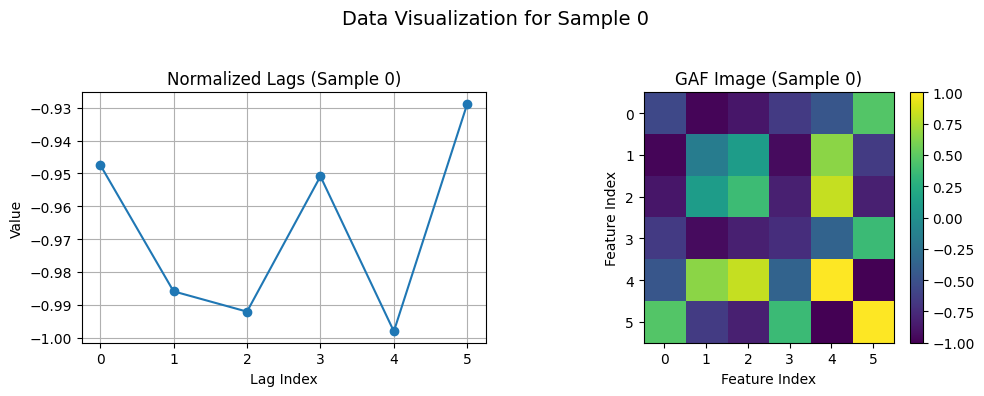

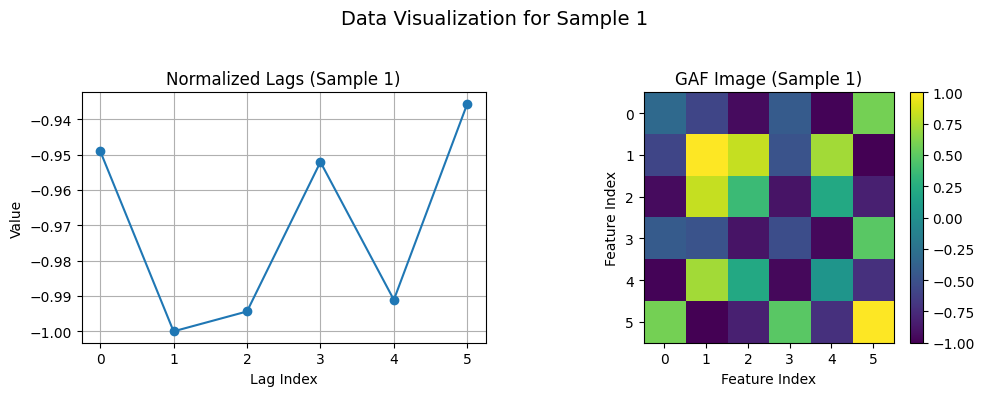

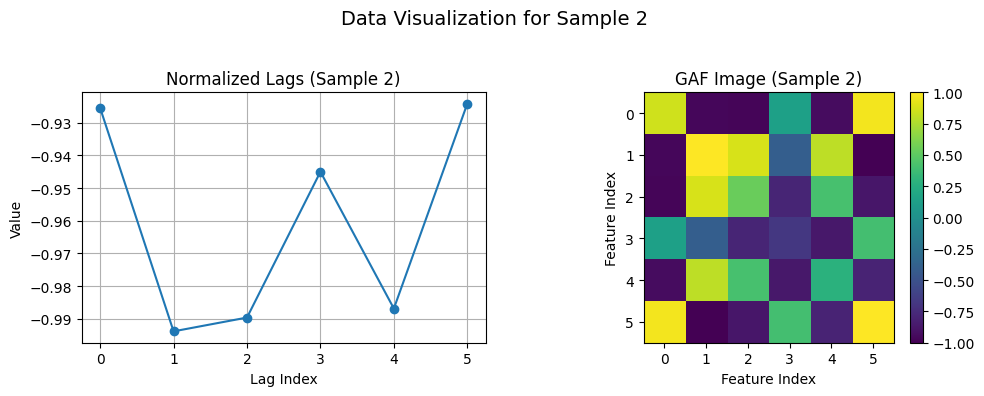

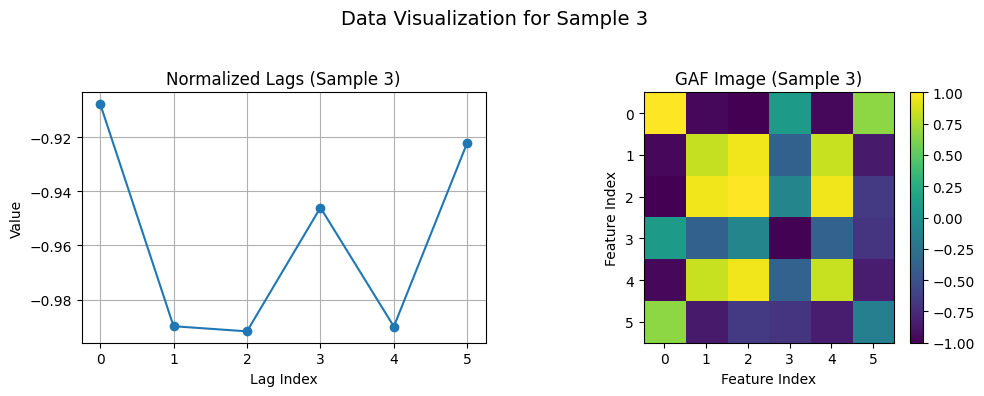

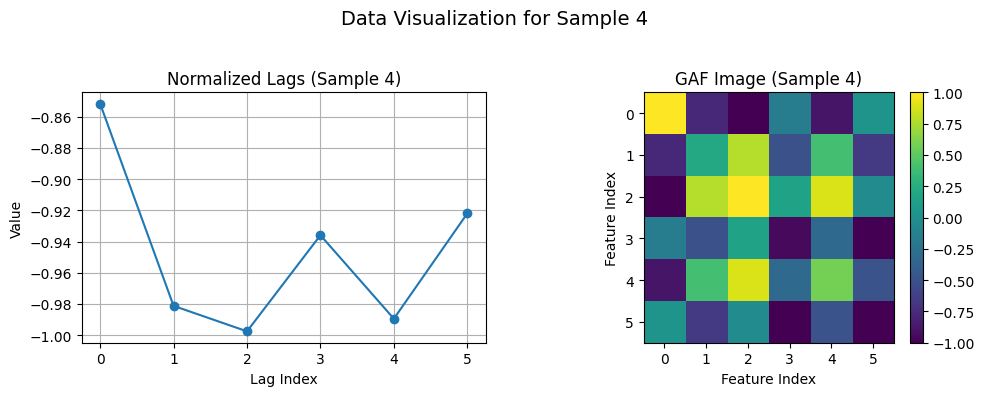

In [56]:
if 'X_Price_train_GAF' not in locals() or 'X_Price_train_normalized' not in locals():
    print("FYI: Using mock data as X_Price_train_GAF or X_Price_train_normalized were not found.")
    _num_samples, _num_features = 10, 6
    X_Price_train_normalized = np.random.rand(_num_samples, _num_features) * 2 - 1
    X_Price_train_GAF = np.random.rand(_num_samples, _num_features, _num_features, 1) * 2 - 1

    for i in range(_num_samples):
        for r_c in range(_num_features):
             X_Price_train_GAF[i, r_c, r_c, 0] = np.cos(2 * np.arccos(X_Price_train_normalized[i, r_c]))


# Visualization: Loop through samples 0 to 4
for sample_index in range(5):
    if sample_index < X_Price_train_GAF.shape[0] and sample_index < X_Price_train_normalized.shape[0]:
        gaf_image_sample = X_Price_train_GAF[sample_index].squeeze()
        original_features_sample = X_Price_train_normalized[sample_index]

        fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        # Plot 1: Original Normalized Lag Features
        axs[0].plot(original_features_sample, marker='o', linestyle='-')
        axs[0].set_title(f"Normalized Lags (Sample {sample_index})")
        axs[0].set_xlabel("Lag Index")
        axs[0].set_ylabel("Value")
        axs[0].set_xticks(range(len(original_features_sample)))
        axs[0].grid(True)

        # Plot 2: GAF Image
        im = axs[1].imshow(gaf_image_sample, cmap='viridis', vmin=-1, vmax=1, origin='upper')
        axs[1].set_title(f"GAF Image (Sample {sample_index})")
        axs[1].set_xlabel("Feature Index")
        axs[1].set_ylabel("Feature Index")
        fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)

        plt.suptitle(f"Data Visualization for Sample {sample_index}", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show() # Display the plot for the current sample

        #print(f"\n--- Sample {sample_index} ---")
        #print(f"Original Normalized Lag Features:\n{original_features_sample}")
        #print(f"GAF Image Matrix:\n{gaf_image_sample}")
        #print("-" * 30) # Separator for clarity
    else:
        print(f"Warning: Sample index {sample_index} is out of range for the available data (max index: {min(X_Price_train_GAF.shape[0]-1, X_Price_train_normalized.shape[0]-1)}). Skipping.")
        break


### HPO

In [57]:
import tensorflow as tf
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras import backend as K

if optHPO:
  # Clear session for reproducibility
  K.clear_session()
  tf.random.set_seed(1234)

  # Define CNN model for Keras Tuner
  class CNN_Tune_Dense(kt.HyperModel):
      def build(self, hp):
          model = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=(6, 6, 1)),

              # CNN layers (unchanged)
              tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"),
              tf.keras.layers.MaxPooling2D((2,2)),
              tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
              tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
              tf.keras.layers.Flatten(),

              # Tune number of dense units
              tf.keras.layers.Dense(
                  units=hp.Choice("dense_units", values=[256, 512, 1024]),
                  activation="relu"
              ),

              # Tune dropout rate
              tf.keras.layers.Dropout(hp.Choice("dropout_rate", values=[0.2, 0.3, 0.5])),

              # Output layer for regression
              tf.keras.layers.Dense(1, activation="linear")
          ])

          model.compile(
              optimizer="adam",
              loss="mean_absolute_error"
          )
          return model

  # Initialize Hyperband tuner
  tuner = kt.Hyperband(
      CNN_Tune_Dense(),
      objective="val_loss",
      max_epochs=50,
      seed=1234,
      overwrite=True,
  )

  # Define EarlyStopping
  early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

  # Perform hyperparameter tuning
  tuner.search(
      X_Price_train_GAF, y_Price_train_normalized,
      validation_split=0.2,
      epochs=50,
      batch_size=32,
      verbose=1,
      callbacks=[early_stopping]
  )

  # Retrieve best hyperparameters
  best_hps_dense = tuner.get_best_hyperparameters(num_trials=1)[0]
  print("Best Hyperparameters for Fully Connected Layers:", best_hps_dense.values)

Trial 9 Complete [00h 00m 14s]
val_loss: 0.3554275333881378

Best val_loss So Far: 0.22430339455604553
Total elapsed time: 00h 02m 09s

Best Hyperparameters for Fully Connected Layers: {'dense_units': 256, 'dropout_rate': 0.2, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}

### Model Training

In [58]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping

# Set TensorFlow seed
tf.random.set_seed(42)

# Clear session to reset the state
K.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(6, 6, X_Price_train_GAF.shape[-1])),

    # Conv2D with 16 filters
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2,2)),

    # Conv2D with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),

    # Conv2D with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),

    tf.keras.layers.Flatten(),

    # Fully connected layers
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="linear")
])

# Define EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Compile the model
model.compile(loss="mean_absolute_error", optimizer="adam", metrics=["mae"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,265 (669.00 KB)

 Trainable params: 171,265 (669.00 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.fit(X_Price_train_GAF, y_Price_train_normalized,
          epochs=1000, batch_size=32,
          validation_data=(X_Price_test_GAF, y_Price_test_normalized),
          callbacks=[early_stop],
          verbose=0)

print("Model training completed successfully!")

Model training completed successfully!


### Performance Evaluation

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure Predictions Use GAF-Transformed Data
y_train_pred_price = model.predict(X_Price_train_GAF)
y_train_actual_price = y_Price_train_normalized

y_test_pred_price = model.predict(X_Price_test_GAF)
y_test_actual_price = y_Price_test_normalized

# Calculate MAE & RMSE for Training & Test Sets
train_mae_price = mean_absolute_error(y_train_actual_price, y_train_pred_price)
train_rmse_price = np.sqrt(mean_squared_error(y_train_actual_price, y_train_pred_price))

test_mae_price = mean_absolute_error(y_test_actual_price, y_test_pred_price)
test_rmse_price = np.sqrt(mean_squared_error(y_test_actual_price, y_test_pred_price))

# Create Performance DataFrame
performance_data_price = {
    "Metric": ["MAE", "RMSE"],
    "Training": [train_mae_price, train_rmse_price],
    "Testing": [test_mae_price, test_rmse_price],
}

performance_df_price = pd.DataFrame(performance_data_price)

# Display Results
print("\nModel Performance for Price-Level Prediction:")
np.round(performance_df_price, 4)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Model Performance for Price-Level Prediction:


,Metric,Training,Testing
0,MAE,0.1751,1.1847
1,RMSE,0.2686,1.3519


## b.Using the GAF representation of the stationary time series, build and train an MLP that is designed to predict the stationary version of the time series.

### Data Preparation

In [61]:
file_id = "1yb7pScch7vynLvhPgxZ1rpwRt18F626G"  # Extract file ID from the link
download_url = f"https://drive.google.com/uc?id={file_id}&export=download"

# Read CSV directly from Google Drive link
BTC_Price = pd.read_csv(download_url, parse_dates = ['Date'], index_col = 'Date')

# Log return computation
BTC_Log_Return = np.log(BTC_Price / BTC_Price.shift(1))

# Rename column from "Close" to "LogReturn"
BTC_Log_Return.rename(columns={"Close": "LogReturn"}, inplace=True)
BTC_Log_Return.dropna(inplace=True)

BTC_Log_Return.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1946 entries, 2020-01-02 to 2025-04-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LogReturn  1946 non-null   float64
dtypes: float64(1)
memory usage: 30.4 KB


In [62]:
# Create the DataFrame using BTC_Log_Return, ensuring column name "LogReturn"
df_BTC_Log_Return = pd.DataFrame(BTC_Log_Return, columns=["LogReturn"])

# Define the lambda function to calculate cumulative log return by summing
# This gives the total log return over the window (ln(Pn/P0))
calculate_cumulative_log_return = lambda x: x.sum()

# Generate accumulated returns for rolling windows of 30, 60, 90, 120, 240, and 360 days
df_BTC_Log_Return["LogRet30_i"] = df_BTC_Log_Return["LogReturn"].rolling(30).apply(calculate_cumulative_log_return, raw=True)
df_BTC_Log_Return["LogRet60_i"] = df_BTC_Log_Return["LogReturn"].rolling(60).apply(calculate_cumulative_log_return, raw=True)
df_BTC_Log_Return["LogRet90_i"] = df_BTC_Log_Return["LogReturn"].rolling(90).apply(calculate_cumulative_log_return, raw=True)
df_BTC_Log_Return["LogRet120_i"] = df_BTC_Log_Return["LogReturn"].rolling(120).apply(calculate_cumulative_log_return, raw=True)
df_BTC_Log_Return["LogRet240_i"] = df_BTC_Log_Return["LogReturn"].rolling(240).apply(calculate_cumulative_log_return, raw=True)
df_BTC_Log_Return["LogRet360_i"] = df_BTC_Log_Return["LogReturn"].rolling(360).apply(calculate_cumulative_log_return, raw=True)

# Shift the target variable (Ret30)
# The target variable 'LogRet30' now represents the cumulative log return over the next 30 days
df_BTC_Log_Return["Ret30"] = df_BTC_Log_Return["LogRet30_i"].shift(-30)
df_BTC_Log_Return.drop('LogReturn', axis= 1, inplace = True)

# Drop rows with missing values resulting from rolling and shifting
df_BTC_Log_Return.dropna(inplace=True)

# Display resulting DataFrame info
df_BTC_Log_Return.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1557 entries, 2020-12-26 to 2025-03-31
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LogRet30_i   1557 non-null   float64
 1   LogRet60_i   1557 non-null   float64
 2   LogRet90_i   1557 non-null   float64
 3   LogRet120_i  1557 non-null   float64
 4   LogRet240_i  1557 non-null   float64
 5   LogRet360_i  1557 non-null   float64
 6   Ret30        1557 non-null   float64
dtypes: float64(7)
memory usage: 97.3 KB


In [63]:
from sklearn.model_selection import train_test_split

# Define input features as lagged log returns
X_LogReturn = df_BTC_Log_Return.iloc[:, :-1]  # Not included current log return

# Define target variable as future log return
y_LogReturn = df_BTC_Log_Return.iloc[:, -1]  # The last column, Ret30 (Total current accumulate 30-day return)

# Define the test size (30% for testing)
test_size = 0.3

# Perform train-test split while preserving temporal order
X_LogReturn_train, X_LogReturn_test, y_LogReturn_train, y_LogReturn_test = train_test_split(
    X_LogReturn, y_LogReturn, test_size=test_size, shuffle=False
)

# Check train and test data sizes
print("Train set size (features):", X_LogReturn_train.shape)
print("Test set size (features):", X_LogReturn_test.shape)
print("Train set size (target):", y_LogReturn_train.shape)
print("Test set size (target):", y_LogReturn_test.shape)

Train set size (features): (1089, 6)
Test set size (features): (468, 6)
Train set size (target): (1089,)
Test set size (target): (468,)


In [64]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scalers for input features (X_LogReturn) and target variable (y_LogReturn)
scaler_X_LogReturn = MinMaxScaler(feature_range = (-1,1))
scaler_y_LogReturn = MinMaxScaler(feature_range = (-1,1))

# Fit the scalers on training data only
X_LogReturn_train_normalized = scaler_X_LogReturn.fit_transform(X_LogReturn_train)
y_LogReturn_train_normalized = scaler_y_LogReturn.fit_transform(y_LogReturn_train.values.reshape(-1, 1))

# Use the fitted scalers to transform the test data
X_LogReturn_test_normalized = scaler_X_LogReturn.transform(X_LogReturn_test)
y_LogReturn_test_normalized = scaler_y_LogReturn.transform(y_LogReturn_test.values.reshape(-1, 1))

# Verify the shapes of the normalized data
print("Normalized Training Set (Features):", X_LogReturn_train_normalized.shape)
print("Normalized Test Set (Features):", X_LogReturn_test_normalized.shape)
print("Normalized Training Set (Target):", y_LogReturn_train_normalized.shape)
print("Normalized Test Set (Target):", y_LogReturn_test_normalized.shape)

Normalized Training Set (Features): (1089, 6)
Normalized Test Set (Features): (468, 6)
Normalized Training Set (Target): (1089, 1)
Normalized Test Set (Target): (468, 1)


In [65]:
from pyts.image import GramianAngularField

# Initialize GAF transformation with correct image size
transformer_LogReturn = GramianAngularField(image_size=6)

# Apply GAF transformation to Log Return dataset (corrected variables)
X_LogReturn_train_GAF = transformer_LogReturn.transform(X_LogReturn_train_normalized)
X_LogReturn_test_GAF = transformer_LogReturn.transform(X_LogReturn_test_normalized)

# Reshape to add channel dimension for CNN input compatibility
X_LogReturn_train_GAF = X_LogReturn_train_GAF.reshape(-1, 6, 6, 1)
X_LogReturn_test_GAF = X_LogReturn_test_GAF.reshape(-1, 6, 6, 1)

# Verify the new shape before proceeding
print("GAF Transformed Train Shape:", X_LogReturn_train_GAF.shape)
print("GAF Transformed Test Shape:", X_LogReturn_test_GAF.shape)

GAF Transformed Train Shape: (1089, 6, 6, 1)
GAF Transformed Test Shape: (468, 6, 6, 1)


### HPO


In [66]:
import tensorflow as tf
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras import backend as K

if optHPO:
    # Clear session for reproducibility
    K.clear_session()
    tf.random.set_seed(1234)

    # Define CNN model for Keras Tuner (Log Return)
    class CNN_Tune_Dense(kt.HyperModel):
        def build(self, hp):
            model = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=(6, 6, 1)),

                # CNN layers
                tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
                tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
                tf.keras.layers.Flatten(),

                # Tune number of dense units
                tf.keras.layers.Dense(
                    units=hp.Choice("dense_units", values=[256, 512, 1024]),
                    activation="relu"
                ),

                # Tune dropout rate
                tf.keras.layers.Dropout(hp.Choice("dropout_rate", values=[0.2, 0.3, 0.5])),

                # Output layer for regression
                tf.keras.layers.Dense(1, activation="linear")
            ])

            model.compile(
                optimizer="adam",
                loss="mean_absolute_error"
            )
            return model

    # Initialize Hyperband tuner
    tuner = kt.Hyperband(
        CNN_Tune_Dense(),
        objective="val_loss",
        max_epochs=50,
        seed=1234,
        overwrite=True,
    )

    # Define EarlyStopping for stability
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    # Perform hyperparameter tuning on Log Return dataset
    tuner.search(
        X_LogReturn_train_GAF, y_LogReturn_train_normalized,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Retrieve best hyperparameters
    best_hps_dense = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best Hyperparameters for Log Return Model:", best_hps_dense.values)


Trial 9 Complete [00h 00m 15s]
val_loss: 0.18237608671188354

Best val_loss So Far: 0.18237608671188354
Total elapsed time: 00h 02m 15s

Best Hyperparameters for Log Return Model: {'dense_units': 512, 'dropout_rate': 0.5, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}

### Model Training

In [67]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping

# Set TensorFlow seed for reproducibility
tf.random.set_seed(42)

# Clear session to reset the state
K.clear_session()

# Define CNN model using correct Log Return data
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(6, 6, X_LogReturn_train_GAF.shape[-1])),

    # Conv2D with 16 filters
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2,2)),

    # Conv2D with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),

    # Conv2D with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),

    tf.keras.layers.Flatten(),

    # Fully connected layers
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="linear")
])

# Define EarlyStopping to monitor validation loss
early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Compile the model with regression loss
model.compile(loss="mean_absolute_error", optimizer="adam", metrics=["mae"])

# Display model summary to confirm architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,233 (1.22 MB)

 Trainable params: 319,233 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Train CNN on Log Return data
model.fit(
    X_LogReturn_train_GAF, y_LogReturn_train_normalized,
    epochs=1000,
    batch_size=32,
    validation_data=(X_LogReturn_test_GAF, y_LogReturn_test_normalized),
    callbacks=[early_stop],
    verbose=0  # Suppress detailed output
)

print("Model training completed successfully!")

Model training completed successfully!


### Performance Evaluation

In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_train_pred_log_return = model.predict(X_LogReturn_train_GAF)
y_train_actual_log_return = y_LogReturn_train_normalized

y_test_pred_log_return = model.predict(X_LogReturn_test_GAF)
y_test_actual_log_return = y_LogReturn_test_normalized

# Calculate MAE & RMSE for Training & Test Sets
train_mae_log_return = mean_absolute_error(y_train_actual_log_return, y_train_pred_log_return)
train_rmse_log_return = np.sqrt(mean_squared_error(y_train_actual_log_return, y_train_pred_log_return))

test_mae_log_return = mean_absolute_error(y_test_actual_log_return, y_test_pred_log_return)
test_rmse_log_return = np.sqrt(mean_squared_error(y_test_actual_log_return, y_test_pred_log_return))

# Create Performance DataFrame
performance_data_log_return = {
    "Metric": ["MAE", "RMSE"],
    "Training": [train_mae_log_return, train_rmse_log_return],
    "Testing": [test_mae_log_return, test_rmse_log_return],
}

performance_df_log_return = pd.DataFrame(performance_data_log_return)

# Display Results
print("\nModel Performance for Log Return Prediction:")
np.round(performance_df_log_return, 4)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Model Performance for Log Return Prediction:


,Metric,Training,Testing
0,MAE,0.1991,0.1916
1,RMSE,0.2649,0.2556


## c. Using the GAF representation of the fractionally-differenced time series, build and train a CNN that is designed to predict the fractionally-differenced version of the time series.

### Data Preparation

In [70]:
file_id = "1yb7pScch7vynLvhPgxZ1rpwRt18F626G"  # Extract file ID from the link
download_url = f"https://drive.google.com/uc?id={file_id}&export=download"

# Read CSV directly from Google Drive link
BTC_Price = pd.read_csv(download_url, parse_dates = ['Date'], index_col = 'Date')
BTC_Price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1947 entries, 2020-01-01 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1947 non-null   float64
dtypes: float64(1)
memory usage: 30.4 KB


In [71]:
def getWeights(d, lags):
    """
    Compute the weights for fractional differencing.
    Parameters:
        d: Fractional differencing order
        lags: Number of lag coefficients
    Returns:
        weights: Array of weights for fractional differencing
    """
    w = [1]  # Start with initial weight of 1
    for k in range(1, lags):
        w.append(-w[-1] * ((d - k + 1) / k))
    w = np.array(w).reshape(-1, 1)  # Convert to column vector
    return w


def ts_differencing(series, order, lag_cutoff):
    """
    Apply fractional differencing to a time series.
    Parameters:
        series: Original time series
        order: Fractional differencing order
        lag_cutoff: Number of lag coefficients to use
    Returns:
        Fractionally differenced series
    """
    weights = getWeights(order, lag_cutoff)  # Compute weights
    diff_series = 0
    for k in range(lag_cutoff):
        diff_series += weights[k] * series.shift(k).fillna(0)  # Apply weights to shifted series
    return diff_series[lag_cutoff:]  # Drop initial NaN values

# Apply fractional differencing to the BTC price series
order = 0.6  # Fractional differencing order
lag_cutoff = 100  # Number of lag coefficients to retain

BTC_FracDiff = ts_differencing(BTC_Price, order, lag_cutoff)

# Drop NaN values caused by the differencing
BTC_FracDiff = BTC_FracDiff.dropna()

BTC_FracDiff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1847 entries, 2020-04-10 to 2025-04-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1847 non-null   float64
dtypes: float64(1)
memory usage: 28.9 KB


In [72]:
# Create lag features using the fractionally differenced BTC price data
df_BTC_FracDiff = pd.DataFrame(BTC_FracDiff)

df_BTC_FracDiff["Lag30"]   = df_BTC_FracDiff["Close"].shift(30)
df_BTC_FracDiff["Lag60"]   = df_BTC_FracDiff["Close"].shift(60)
df_BTC_FracDiff["Lag90"]   = df_BTC_FracDiff["Close"].shift(90)
df_BTC_FracDiff["Lag120"]  = df_BTC_FracDiff["Close"].shift(120)
df_BTC_FracDiff["Lag240"]  = df_BTC_FracDiff["Close"].shift(240)
df_BTC_FracDiff["Lag360"]  = df_BTC_FracDiff["Close"].shift(360)

# Create target variable
df_BTC_FracDiff["Price30"] = df_BTC_FracDiff["Lag30"].shift(-30)

# Drop rows with missing values
df_BTC_FracDiff.dropna(inplace=True)

# Drop the original 'FracDiff' column (optional)
df_BTC_FracDiff.drop('Close', axis=1, inplace=True)
df_BTC_FracDiff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1457 entries, 2021-04-05 to 2025-03-31
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Lag30    1457 non-null   float64
 1   Lag60    1457 non-null   float64
 2   Lag90    1457 non-null   float64
 3   Lag120   1457 non-null   float64
 4   Lag240   1457 non-null   float64
 5   Lag360   1457 non-null   float64
 6   Price30  1457 non-null   float64
dtypes: float64(7)
memory usage: 91.1 KB


In [73]:
from sklearn.model_selection import train_test_split

# Define input features from the fractionally differenced BTC price data
X_FracDiff = df_BTC_FracDiff.iloc[:, :-1]  # Exclude the last column (target variable)

# Define target variable as future price level
y_FracDiff = df_BTC_FracDiff.iloc[:, -1]  # Only the last column (target variable)

# Define the test size (e.g., 30% test data)
test_size = 0.3

# Perform train-test split while preserving temporal order
X_FracDiff_train, X_FracDiff_test, y_FracDiff_train, y_FracDiff_test = train_test_split(
    X_FracDiff, y_FracDiff, test_size=test_size, shuffle=False
)

# Check train and test data sizes
print("Train set size (features):", X_FracDiff_train.shape)
print("Test set size (features):", X_FracDiff_test.shape)
print("Train set size (target):", y_FracDiff_train.shape)
print("Test set size (target):", y_FracDiff_test.shape)

Train set size (features): (1019, 6)
Test set size (features): (438, 6)
Train set size (target): (1019,)
Test set size (target): (438,)


In [74]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scalers for fractionally differenced data (X_FracDiff) and target price (y_FracDiff)
scaler_X_FracDiff = MinMaxScaler(feature_range=(-1,1))
scaler_y_FracDiff = MinMaxScaler(feature_range=(-1,1))

# Fit the scalers on training data only
X_FracDiff_train_normalized = scaler_X_FracDiff.fit_transform(X_FracDiff_train)
y_FracDiff_train_normalized = scaler_y_FracDiff.fit_transform(y_FracDiff_train.values.reshape(-1, 1))

# Use the fitted scalers to transform the test data
X_FracDiff_test_normalized = scaler_X_FracDiff.transform(X_FracDiff_test)
y_FracDiff_test_normalized = scaler_y_FracDiff.transform(y_FracDiff_test.values.reshape(-1, 1))

# Display the resulting dimensions for confirmation
print("Train set size (normalized features):", X_FracDiff_train_normalized.shape)
print("Test set size (normalized features):", X_FracDiff_test_normalized.shape)
print("Train set size (normalized target):", y_FracDiff_train_normalized.shape)
print("Test set size (normalized target):", y_FracDiff_test_normalized.shape)

Train set size (normalized features): (1019, 6)
Test set size (normalized features): (438, 6)
Train set size (normalized target): (1019, 1)
Test set size (normalized target): (438, 1)


In [75]:
from pyts.image import GramianAngularField

# Initialize GAF transformation with correct image size
transformer_FracDiff = GramianAngularField(image_size=6)

# Apply GAF transformation to fractionally differenced dataset
X_FracDiff_train_GAF = transformer_FracDiff.transform(X_FracDiff_train_normalized)
X_FracDiff_test_GAF = transformer_FracDiff.transform(X_FracDiff_test_normalized)

# Reshape to add channel dimension for CNN input compatibility
X_FracDiff_train_GAF = X_FracDiff_train_GAF.reshape(-1, 6, 6, 1)
X_FracDiff_test_GAF = X_FracDiff_test_GAF.reshape(-1, 6, 6, 1)

print("GAF Transformed Train Shape:", X_FracDiff_train_GAF.shape)
print("GAF Transformed Test Shape:", X_FracDiff_test_GAF.shape)

GAF Transformed Train Shape: (1019, 6, 6, 1)
GAF Transformed Test Shape: (438, 6, 6, 1)


### HPO

In [76]:
import tensorflow as tf
import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras import backend as K

if optHPO:  #
    # Clear session for reproducibility
    K.clear_session()
    tf.random.set_seed(1234)

    # Define CNN model for Keras Tuner (Fractionally Differenced Data)
    class CNN_Tune_Dense(kt.HyperModel):
        def build(self, hp):
            model = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=(6, 6, 1)),

                # CNN layers (unchanged)
                tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"),
                tf.keras.layers.MaxPooling2D((2,2)),
                tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
                tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
                tf.keras.layers.Flatten(),

                # Tune number of dense units
                tf.keras.layers.Dense(
                    units=hp.Choice("dense_units", values=[256, 512, 1024]),
                    activation="relu"
                ),

                # Tune dropout rate
                tf.keras.layers.Dropout(hp.Choice("dropout_rate", values=[0.2, 0.3, 0.5])),

                # Output layer for regression
                tf.keras.layers.Dense(1, activation="linear")
            ])

            model.compile(
                optimizer="adam",
                loss="mean_absolute_error"
            )
            return model

    # Initialize Hyperband tuner
    tuner = kt.Hyperband(
        CNN_Tune_Dense(),
        objective="val_loss",
        max_epochs=50,
        seed=1234,
        overwrite=True,
    )

    # Define EarlyStopping for stability
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    # Perform hyperparameter tuning on Fractionally Differenced dataset
    tuner.search(
        X_FracDiff_train_GAF, y_FracDiff_train_normalized,  # Corrected dataset
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Retrieve best hyperparameters
    best_hps_dense = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best Hyperparameters for Fractionally Differenced Data Model:", best_hps_dense.values)

Trial 9 Complete [00h 00m 16s]
val_loss: 0.10657777637243271

Best val_loss So Far: 0.10391262173652649
Total elapsed time: 00h 02m 21s

Best Hyperparameters for Fractionally Differenced Data Model: {'dense_units': 512, 'dropout_rate': 0.2, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}


### Model Training

In [77]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping

# Set TensorFlow seed for reproducibility
tf.random.set_seed(42)

# Clear session to reset the state
K.clear_session()

# Define CNN model using correct fractionally differenced dataset
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(6, 6, X_FracDiff_train_GAF.shape[-1])),

    # Conv2D with 16 filters
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2,2)),

    # Conv2D with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),

    # Conv2D with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),

    tf.keras.layers.Flatten(),

    # Fully connected layers
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="linear")  # Regression output layer
])

# Define EarlyStopping to monitor validation loss
early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Compile the model with regression loss
model.compile(loss="mean_absolute_error", optimizer="adam", metrics=["mae"])

# Display model summary to confirm architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 6, 6, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,233 (1.22 MB)

 Trainable params: 319,233 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Train CNN on fractionally differenced data
model.fit(
    X_FracDiff_train_GAF, y_FracDiff_train_normalized,
    epochs=1000,
    batch_size=32,
    validation_data=(X_FracDiff_test_GAF, y_FracDiff_test_normalized),
    callbacks=[early_stop],
    verbose=0  # Suppress detailed output
)

print("Model training completed successfully!")

Model training completed successfully!


### Performance Evaluation

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure Predictions Use GAF-Transformed Fractionally Differenced Data
y_train_pred_fracdiff = model.predict(X_FracDiff_train_GAF)
y_train_actual_fracdiff = y_FracDiff_train_normalized

y_test_pred_fracdiff = model.predict(X_FracDiff_test_GAF)
y_test_actual_fracdiff = y_FracDiff_test_normalized

# Calculate MAE & RMSE for Training & Test Sets
train_mae_fracdiff = mean_absolute_error(y_train_actual_fracdiff, y_train_pred_fracdiff)
train_rmse_fracdiff = np.sqrt(mean_squared_error(y_train_actual_fracdiff, y_train_pred_fracdiff))

test_mae_fracdiff = mean_absolute_error(y_test_actual_fracdiff, y_test_pred_fracdiff)
test_rmse_fracdiff = np.sqrt(mean_squared_error(y_test_actual_fracdiff, y_test_pred_fracdiff))

# Create Performance DataFrame
performance_data_fracdiff = {
    "Metric": ["MAE", "RMSE"],
    "Training": [train_mae_fracdiff, train_rmse_fracdiff],
    "Testing": [test_mae_fracdiff, test_rmse_fracdiff],
}

performance_df_fracdiff = pd.DataFrame(performance_data_fracdiff)

# Display Results
print("\nModel Performance for Fractionally Differenced Data Prediction:")
np.round(performance_df_fracdiff, 4)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Model Performance for Fractionally Differenced Data Prediction:


,Metric,Training,Testing
0,MAE,0.1347,0.2975
1,RMSE,0.1974,0.3938
